# Unmixing river sediments for the elemental geochemistry of their source regions 

This notebook provides a minimum working example demonstrating how to invert river sediment geochemistry for the composition of their source regions. This notebook was written using `python 3.85`. 



### Set-up 


In [1]:
import netCDF4
import time
import scipy as sp
import numpy as np
import pandas as pd
import nelder_mead
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator,SinkFillerBarnes
from landlab.components.flow_accum.flow_accum_bw import find_drainage_area_and_discharge
from landlab.utils import get_watershed_mask

## Data preprocessing 

### Topography 

Topography is loaded in and used to set up a `LandLab` model grid. This topographic grid has depressions filled prior to drainage-routing. The resulting topographic grid is shown below. Topographic displayed here is `SRTM1s` data downsampled to a 200x200 grid.

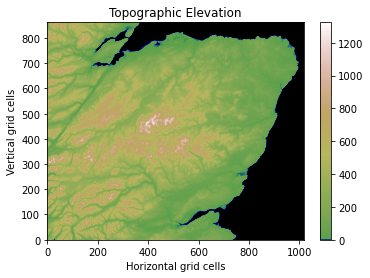

In [2]:
z = np.loadtxt("data/topo.dat")
mg = RasterModelGrid(z.shape,xy_spacing=(200,200))
zr = mg.add_zeros('node', 'topographic__elevation')
zr += np.reshape(z,z.size)
dx = 200

# Set up the boundary conditions on the square grid
mg.set_fixed_value_boundaries_at_grid_edges(True,True,True,True)

flat_shape = zr.shape # a tuple to flatten arrays [number of nodes long]
full_shape = mg.shape # the full shape of the grid [rows, columns]

sfb = SinkFillerBarnes(mg, method='D8',fill_flat=False) # Fill pits
sfb.run_one_step()

# Display topography
plt.figure()
plt.title("Topographic Elevation")
plt.imshow(zr.reshape(full_shape),cmap='gist_earth',origin='lower',norm=TwoSlopeNorm(vcenter=10))
plt.colorbar()
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.show()

### Drainage 

Drainage is extracted from the topography using the `D8` algorithm. This modelled drainage network is then used to calculate the upstream area for every point in the grid. 

In [3]:
frr = FlowAccumulator(
    mg,
    'topographic__elevation',
    flow_director = 'FlowDirectorD8')
frr.run_one_step()  # flow routing

a, q_homo_incis = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node']) # a is number of nodes

area = mg.at_node['drainage_area']
area_threshold = 25 
is_drainage = area > (area_threshold*1000000) #km2 to m2
channel_xy = np.flip(np.transpose(np.where(is_drainage.reshape(mg.shape))),axis=1)*200 # xy coordinates of channels

### Sample Localities 

The location of samples on channels is fitted the drainage network automatically, but then manually checked and adjusted where necessary. This manual check makes sure the locality's location on the _model_ drainage network is the correction location. These localities are displayed below. 

Text(0, 0.5, 'Vertical grid cells')

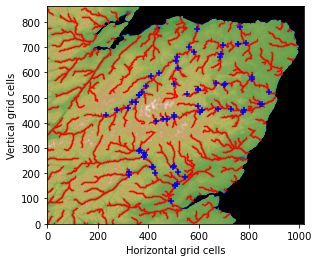

In [4]:
fitted_locs = np.loadtxt("data/fitted_samp_locs.dat") # Fitted drainage locations
sample_data = np.loadtxt("data/samples.dat",dtype=str) # [sample #, locality #, x, y] # x,y, in lat long coordinates


loc_indxs = np.transpose(np.flip((fitted_locs).astype(int),axis=1))
loc_nodes = np.ravel_multi_index(loc_indxs,dims=full_shape) # model grid node IDs

# Load in sample localities 
plt.imshow(zr.reshape(full_shape),cmap='gist_earth',origin='lower',norm=TwoSlopeNorm(vcenter=10))
plt.scatter(x=channel_xy[:,0]/mg.dx, y=channel_xy[:,1]/mg.dx,c='red', s=0.1)
plt.scatter(x=fitted_locs[:,0], y=fitted_locs[:,1], marker="+",c='b', s=40)
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')


### Geochemical Data 

The geochemical data gathered at each of the above localities is loaded into memory and reformatted in a way that is easy indexable (using pandas). 

In [5]:
geochem_raw = np.loadtxt('data/geochem.dat',dtype=str) # Read in data
geochem_raw = np.delete(geochem_raw,[7,53],1) # Delete columns for S and Bi (too many NAs)
elems = geochem_raw[0,1:54] # List of element strings
obs_data = pd.DataFrame(geochem_raw[1:,],columns=geochem_raw[0,:]) # Cast to DataFrame for quick access
obs_data[elems]=obs_data[elems].astype(float) # Cast numeric data to float

## Setting up an inversion grid 

We perform an inversion on a grid generally much coarser than the base topographic grid shown above. Generally we refer to this coarse grid as consisting of 'blocks'. Hence, we define an algorithm that upsamples, or 'expands' a coarser inversion grid onto the same resolution as the base topography. 

In [6]:
model_width = mg.shape[1] # number of x cells in topographic model grid
model_height = mg.shape[0] # number of y cells in topographic model grid

def expand(block_grid,block_x,block_y):
    """Expands low res array of block heights into 
    model grid array that can be fed into topographic
    model. Note that blocks at the upper and eastern 
    perimeter are clipped if number of blocks doesn't 
    divide number of model cells. 
    
    block_x and block_y are the number of model cells 
    in each block in x and y dir respectively"""
    return(block_grid.repeat(block_y, axis=0).repeat(block_x, axis=1)[:model_height,:model_width])


Dividing our model grid up into a suite of 'blocks' may mean that some 'blocks' lie outside of our drainage basins. We don't want to consider these blocks as our samples will not contain any useful information about this part of the grid, as they lie outside of their upstream area. Hence, now we determine which blocks, for a given coarse grid dimensions, like outside of the 'active' study area. The active study area is defined as the region lying upstream of the most downstream samples on each drainage basin. 

An example of the coverage area, and the corresponding 'active blocks' for the example of 10x10 inversion grid is displayed.

Text(0, 0.5, 'Vertical Inversion Blocks')

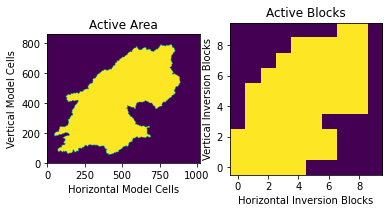

In [7]:
lowest_tay_sample = loc_nodes[sample_data[:,1]=='55'] # Locality 55
tay_catchment = get_watershed_mask(mg,lowest_tay_sample) # extract upstream area of most downstream tay sample 

lowest_dee_sample = loc_nodes[sample_data[:,1]=='7'] # Locality 7. 
dee_catchment = get_watershed_mask(mg,lowest_dee_sample)

lowest_don_sample = loc_nodes[sample_data[:,1]=='34'] # Locality 34. 
don_catchment = get_watershed_mask(mg,lowest_don_sample)

lowest_spey_sample = loc_nodes[sample_data[:,1]=='28'] # Locality 28. 
spey_catchment = get_watershed_mask(mg,lowest_spey_sample)

lowest_deveron_sample = loc_nodes[sample_data[:,1]=='40'] # Locality 28. 
deveron_catchment = get_watershed_mask(mg,lowest_deveron_sample)

active_area = tay_catchment | dee_catchment | don_catchment | spey_catchment | deveron_catchment

def get_active_blocks(nx,ny):
    """For a given number of blocks in the x 
    and y direction (nx & ny), returns a (ny,nx) 
    bool array saying if cell overlaps with active 
    area or not. """
    
    block_width = np.ceil(model_width/nx) 
    block_height = np.ceil(model_height/ny)

    model_grid_block_indices = np.zeros((model_height,model_width,2))    
    for i in np.arange(model_height):
        for j in np.arange(model_width):
            model_grid_block_indices[i,j,0] = i//block_height
            model_grid_block_indices[i,j,1] = j//block_width
    model_grid_block_indices = model_grid_block_indices.astype(int)        
    # 3D array that contains index of block that model cell corresponds to 
    # ([:,:,0] = y coordinate; [:,:,1] = x coordinate)
    
    out = np.zeros((ny,nx)).astype(bool)
    for i in np.arange(ny):
        for j in np.arange(nx):
            # Boolean array of model cells that correspond to block indeix (i,j)
            cells_in_block = np.logical_and(model_grid_block_indices[:,:,0] == i, model_grid_block_indices[:,:,1] == j)
            # Returns if block overlap with active area:
            out[i,j] = np.any(np.logical_and(cells_in_block,active_area.reshape(full_shape)))
    return(out)

active_blocks = get_active_blocks(10,10)

plt.subplot(1,2,1)
plt.imshow(active_area.reshape(full_shape),origin='lower')
plt.title("Active Area")
plt.xlabel("Horizontal Model Cells")
plt.ylabel("Vertical Model Cells")

plt.subplot(1,2,2)
plt.imshow(active_blocks,origin='lower')
plt.title("Active Blocks")
plt.xlabel("Horizontal Inversion Blocks")
plt.ylabel("Vertical Inversion Blocks")


### Defining initial conditions - Naive

For our inversion we need to specify an initial conditions, or a 'first guess' which the optimisation algorithm then tries to improve. For an initial guess we use the average composition of all the _most downstream_ sediment samples from each basin, weighted by their upstream area. This is then used as a homogenous composition across the entire area. This is defined below. 


In [8]:
obs_elems = obs_data[elems]
spey_mth_comp = np.asarray(obs_elems[obs_data['locality'] == '28'])
dee_mth_comp = np.asarray(obs_elems[obs_data['locality'] == '7'])
dev_mth_comp = np.asarray(obs_elems[obs_data['locality'] == '40'])
tay_mth_comp = np.asarray(obs_elems[obs_data['locality'] == '55'])
don_mth_comp = np.asarray(obs_elems[obs_data['locality'] == '34'])

prior_wtd_avg = pd.DataFrame((spey_mth_comp*3012.24 + dee_mth_comp*2009.64 + dev_mth_comp*1407.12 + 
           tay_mth_comp*5096.36 + don_mth_comp*1330.4)/(3012.24+2009.64+1407.12+5096.36+1330.4))
prior_wtd_avg.columns = elems
prior_wtd_avg = np.mean(prior_wtd_avg,axis=0)
prior_wtd_avg_log = np.log(prior_wtd_avg)


### Initiating an inversion 

Putting this together we can therefore define a function that initiates an inversion grid at this initial condition for a given element and returns a boolean array which indexes the active and inactive blocks.  

In [9]:
def initiate_blocky_inversion_naive(nx,ny,elem):
    """Initiates an inversion grid for given number of 
    cells and element. """
    blox = np.zeros((ny,nx)) + prior_wtd_avg_log[elem] # Set block height to prior in log space
    active_blox = get_active_blocks(nx,ny) # Active cells
    block_x_step = np.ceil(model_width/nx) # Block width
    block_y_step = np.ceil(model_height/ny) # Block height
    
    return blox,active_blox,block_x_step,block_y_step

### Initiating inversion close to the solution

The above approach is simple but starts the solution relatively far from the solution. We can improve runtime by starting the optimisation a bit closer to the optimal solution. We can do this by setting each unique nested catchment to the composition of that sample. Then, for each block in the inversion we then take the average of the upstream geochemistry. This initial condition is a better starting solution. 

First we identify the full upstream area of each sample site (note this is a little slow but only needs to be done once)

In [10]:
unique_locs = np.unique(sample_data[:,1])
loc_areas = []
for loc_num in unique_locs:
    sample_node_num = loc_nodes[sample_data[:,1]==loc_num]
    if(sample_node_num.size==2): # Catch duplicate sample exception
        sample_node_num = sample_node_num[0]
    upst_area = get_watershed_mask(mg,sample_node_num)
    loc_areas = loc_areas + [upst_area]
loc_areas = np.array(loc_areas) # The full (not unique) upstream area for each sample site.

Now, we define functions that fetch the unique upstream area for each sample site.  

In [11]:
def loc_to_area(loc):
    """Returns the catchment mask for a given locality"""
    return(loc_areas[np.where(unique_locs == loc)])

def b_is_nested_in_a(a,b):
    """Is catchment 'b' a nested subcatchment of catchment 'a'?"""
    return(not(np.any(np.invert(np.logical_or(a,np.invert(b))))))

def which_locs_are_contained_upstream_of(loc_a):
    """Which localities define subcatchments of area defined by loc 'a'"""
    loc_area = loc_to_area(loc_a)
    out_locs = []
    for loc_num in unique_locs:
        if(not(loc_num==loc_a)):
            upst_area = loc_to_area(loc_num)
            if(b_is_nested_in_a(loc_area,upst_area)):
                out_locs = out_locs + [loc_num]
    return(out_locs)


def find_unique_seg(loc):
    locs_upstream_of_ = which_locs_are_contained_upstream_of(loc)
    downstream_area = loc_to_area(loc)
    out = np.zeros(active_area.size).astype(bool)
    for upstream_loc in locs_upstream_of_:
        out = np.logical_or(out,loc_to_area(upstream_loc))
    unique_seg = np.logical_and(downstream_area,np.invert(out))
    return(unique_seg.reshape(active_area.shape))

Now, with these functions defined we can define a 'smart' initiation that sets the nodes to a composition close to the nearest downstream location.

In [13]:
def initiate_blocky_inversion_smart(nx,ny,elem):
    """Initiates an inversion grid for given number of 
    cells and element. """
    
    # Define full-res starting solution
    full_init = np.zeros(active_area.shape) + prior_wtd_avg_log[elem]  
    for loc_num in unique_locs:
        values = np.asarray(obs_elems[elem][obs_data['locality'] == loc_num])
        if(values.size==2): # Catch duplicate sample exception
            full_init[find_unique_seg(loc_num)] = np.mean(np.log(values))
        else:
            full_init[find_unique_seg(loc_num)] = np.log(values)

    # Define inversion nodes
    blox = np.zeros((ny,nx))
    active_blox = get_active_blocks(nx,ny) # Active cells
    
    block_x_step = np.ceil(model_width/nx) # Block width
    block_y_step = np.ceil(model_height/ny) # Block height
    
    # Downsample initial guess
    model_grid_block_indices = np.zeros((model_height,model_width,2))
    for i in np.arange(model_height):
        for j in np.arange(model_width):
            model_grid_block_indices[i,j,0] = i//block_y_step
            model_grid_block_indices[i,j,1] = j//block_x_step
    model_grid_block_indices = model_grid_block_indices.astype(int)
    # 3D array that contains index of block that model cell corresponds to
    # ([:,:,0] = y coordinate; [:,:,1] = x coozzzrdinate)
     
    for i in np.arange(ny):
        for j in np.arange(nx):
            # Boolean array of model cells that correspond to block indeix (i,j)
            cells_in_block = np.logical_and(model_grid_block_indices[:,:,0] == i, model_grid_block_indices[:,:,1] == j)
            # Returns if block overlap with active area:
            blox[i,j] = np.mean(full_init.reshape(full_shape)[cells_in_block])
    blox[np.invert(active_blox)] =  prior_wtd_avg_log[elem]     
    return blox,active_blox,block_x_step,block_y_step

## Cost functions

Here we define the cost-functions we use to define an objective function and hence invert our downstream samples. 

### Data misfit

This function calculates the data-misfit between the predicted geochemical composition at sample sites and the true observations.

In [14]:
def data_misfit(bdrck_arr,elem):
    """Returns L2norm data misfit for a given bedrock input array (mgkg), calculating predictions for given element assuming homogenous incision"""
    a, sed_comp = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node'],runoff = bdrck_arr)  # composition but homogeneous erosion
    sed_comp_norm = sed_comp/q_homo_incis
    l2norm = np.linalg.norm(np.log10(obs_data[elem]) - np.log10(sed_comp_norm[loc_nodes]))
    return(l2norm)   

### Roughness

This function calculates the x and y components of roughness for a given inversion array

In [15]:
def cost_roughness(blox,active_blox,block_x,block_y):
    """Returns l2 norm of roughness in both directions. 
    Assumes Von Neumann BCs dC/dx = dC/dy = 0"""
    copy = np.copy(blox)
    # Set von neumann BCs
    copy[np.invert(active_blox)] = 'nan' # set inactive nodes to 'nan'
    padded = np.pad(copy,pad_width=1,mode='constant',constant_values='nan') # pad with 'nan' too
    x_diffs = np.diff(padded,axis=1)/block_x # dC/dx
    y_diffs = np.diff(padded,axis=0)/block_y # dC/dy
    x_rough = np.sqrt(np.nansum(x_diffs**2)) # sqrt(SUM((dC/dx)^2)), NB 'nans' are treated as zeros using nansum.
    y_rough = np.sqrt(np.nansum(y_diffs**2)) # sqrt(SUM((dC/dy)^2))
    return(x_rough,y_rough) # return tuple of roughness along both axes


### Objective Function 

These two separate cost functions are hence combined to create an objective function that penalises both data-misfit and roughness. The smoothing coefficient `lamda` must be specified. 

In [16]:
def smoothed_objective(param_arr,blox,active_blox,block_xstep,block_ystep,elem,lamda_):
    """Tests a given parameter array `param_arr` for the given inversion setup. 
    Returns the least squares damped cost. Each iteration is ~25 ms"""
    blox[active_blox] = param_arr # Update model grid with new parameters; 1.25 us
    bedrock = expand(np.exp(blox),block_xstep,block_ystep) # Convert log blocks into continuous grid in mg/kg; 3.5 ms
    data_sq = data_misfit(bedrock.reshape(flat_shape),elem)**2 # Calculate data misfit; 19.4 ms
    rough_x,rough_y = cost_roughness(blox,active_blox,block_xstep,block_ystep) # Calculate roughness; 68 us
    roughness_sq = (lamda_**2)*(rough_x**2 + rough_y**2) # Roughness squared; 0.6 us
    return(data_sq+roughness_sq)

## Comparing the initiation methods

To see the effect of starting closer to the solution we now look at the data-misfit between the initial guesses for the naive and fast approach.

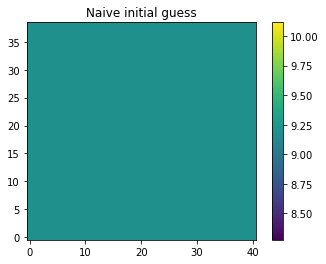

Data misfit for naive inversion
4.47916400704


/home/alex/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Data misfit for smart inversion
1.00687427164


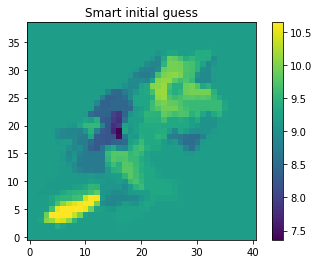

In [17]:
elem='Mg'
nx=41
ny=39

blocks,active_blocks,block_x,block_y = initiate_blocky_inversion_naive(nx,ny,elem)
plt.imshow(blocks,origin='lower')
plt.title("Naive initial guess")
plt.colorbar()
plt.show()

bedrock = expand(np.exp(blocks),block_x,block_y) # Convert log blocks into continuous grid in mg/kg; 3.5 ms
data_sq = data_misfit(bedrock.reshape(flat_shape),elem)**2 # Calculate data misfit; 19.4 ms
print("Data misfit for naive inversion")
print(data_sq)

blocks,active_blocks,block_x,block_y = initiate_blocky_inversion_smart(nx,ny,elem)

bedrock = expand(np.exp(blocks),block_x,block_y) # Convert log blocks into continuous grid in mg/kg; 3.5 ms
data_sq = data_misfit(bedrock.reshape(flat_shape),elem)**2 # Calculate data misfit; 19.4 ms
print("Data misfit for smart inversion")
print(data_sq)

plt.imshow(blocks,origin='lower')
plt.title("Smart initial guess")
plt.colorbar()
plt.show() 

# Inverting

The following chunk represents a minimum working example inversion using the code defined above. We invert for the best fitting upstream geochemistry of Magnesium using an inversion resolution of ~20x16 km (inversion grid of 10x10) and a smoothing coefficient of 2 ~ $10^{0.3}$. This is coarser than the grid used in the manuscript so that it converges in a quicker amount of time. This takes ~25 minutes to converge on a standard desktop with Intel i7 processor. Note that the default output of the Nelder-Mead algorithm in `SciPy` produces *no output during convergence.* The convergence information displayed below was produced by modifying the source-code for the `SciPy` optimisation algorithm.

Starting Nelder-Mead iterations...
Iteration number 1000
2021-08-05 13:25:53.896297
Objective function: 1.24478488923
log10(F change)= -1.63459942042
log10(x change)= -1.12434059452
##################################
Iteration number 2000
2021-08-05 13:26:18.786014
Objective function: 1.15502867519
log10(F change)= -2.34663119091
log10(x change)= -1.23473781085
##################################
Iteration number 3000
2021-08-05 13:26:49.175218
Objective function: 1.13488070509
log10(F change)= -2.83315627803
log10(x change)= -1.63249700449
##################################
Iteration number 4000
2021-08-05 13:27:15.097038
Objective function: 1.12897688928
log10(F change)= -3.36504628921
log10(x change)= -1.87317373483
##################################
Iteration number 5000
2021-08-05 13:27:39.298473
Objective function: 1.12638786771
log10(F change)= -3.6812612922
log10(x change)= -2.0829783056
##################################
Iteration number 6000
2021-08-05 13:28:02.766105
Objectiv

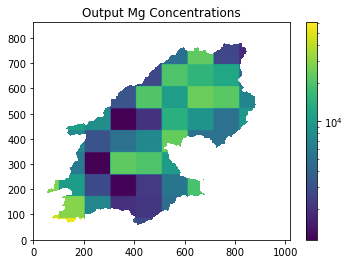

In [37]:
nx=10   # <<<<<<<<<<<<<<<<   Change number of x blocks in inversion grid
ny=10  # <<<<<<<<<<<<<<<<   Change number of y blocks in inversion grid
lamda=2 # <<<<<<<<<<<<<<<<   Change smoothing coefficient 
elem='Mg' # <<<<<<<<<<<<<<<<  Change element being inverted

### Initiating inversion ####

blocks,active_blocks,block_width,block_height = initiate_blocky_inversion_smart(nx,ny,elem)
parameters = np.copy(blocks[active_blocks]) # The array we will vary. 

#### Perform inversion ####

start = time.time()
res_nm = nelder_mead.minimize_rel(func=smoothed_objective,args=(blocks,active_blocks,block_width,block_height,elem,lamda),x0=parameters,
                                 xatol=1e-3, fatol=1e-3, adaptive=True,display=1000,maxiter=1e7,maxfev=1e7)
end = time.time()

#### Finish ####

print("############ results ############")
print("Runtime = ",end-start,"s")
print(res_nm.success) 
print(res_nm.status)
print(res_nm.message)
print(res_nm.nit)

expanded = expand(np.exp(blocks),block_width,block_height)
expanded[np.invert(active_area.reshape(full_shape))] = 'nan'
plt.imshow(expanded,origin='lower',norm=LogNorm())
plt.colorbar()
plt.title("Output Mg Concentrations")
plt.show()

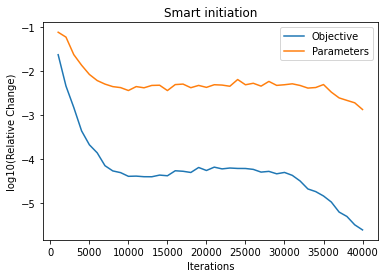

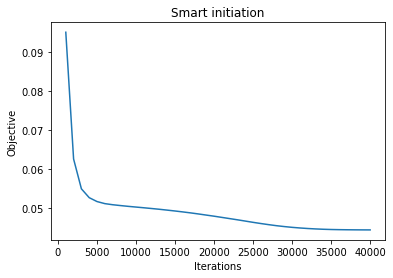

In [38]:
convergence_dat_fast = np.loadtxt("neldermead_rel/convergence.dat",dtype=float)
plt.plot(convergence_dat_fast[:,0],np.log10(convergence_dat_fast[:,2]))
plt.plot(convergence_dat_fast[:,0],np.log10(convergence_dat_fast[:,3]))
plt.legend(["Objective","Parameters"])
plt.xlabel("Iterations")
plt.ylabel("log10(Relative Change)")
plt.title("Smart initiation")
plt.show() 

plt.plot(convergence_dat_fast[:,0],np.log10(convergence_dat_fast[:,1]))
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.title("Smart initiation")
plt.show() 

# Inverting with a different optimisation algorithm 

Now we explore whether we can use a faster optimisation algorithm than the Nelder-Mead (which whilst robust is a little slow). We try Powell's algorithm first.

Initiating
Inverting
Optimization terminated successfully.
         Current function value: 0.841540
         Iterations: 12
         Function evaluations: 83732
############ results ############
Runtime =  1645.6402864456177 s
True
0
Optimization terminated successfully.
12


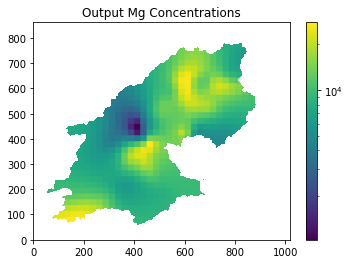

In [62]:
nx=41   # <<<<<<<<<<<<<<<<   Change number of x blocks in inversion grid
ny=39  # <<<<<<<<<<<<<<<<   Change number of y blocks in inversion grid
lamda=2 # <<<<<<<<<<<<<<<<   Change smoothing coefficient 
elem='Mg' # <<<<<<<<<<<<<<<<  Change element being inverted

### Initiating inversion ####
print("Initiating")
blocks,active_blocks,block_width,block_height = initiate_blocky_inversion_smart(nx,ny,elem)
parameters = np.copy(blocks[active_blocks]) # The array we will vary. 

#### Perform inversion ####
print("Inverting")
start = time.time()
res_nm = sp.optimize.minimize(fun=smoothed_objective,args=(blocks,active_blocks,block_width,block_height,elem,lamda),x0=parameters,method='Powell',
                                  options={'disp':True,'xtol':1e-3,'ftol':1e-3})
end = time.time()

#### Finish ####

print("############ results ############")
print("Runtime = ",end-start,"s")
print(res_nm.success) 
print(res_nm.status)
print(res_nm.message)
print(res_nm.nit)

expanded_powell = expand(np.exp(blocks),block_width,block_height)
expanded_powell[np.invert(active_area.reshape(full_shape))] = 'nan'
plt.imshow(expanded_powell,origin='lower',norm=LogNorm(),cmap='magma')
plt.colorbar()
plt.title("Output Mg Concentrations")
plt.show()

This produces a map practically identical to that produced by Nelder Mead but in a fraction of the time, in just 30 minutes.